# BIST100 ENDEKSİ

In [1]:
# Veri okuma ve işleme adımında kullanılacak kütüphaneler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# !pip install tensorflow
import tensorflow as tf

# Model için kullanılacak kütüphaneler
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Model değerlendirme ve veri ölçeklendirmede kullanılacak kütüphaneler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Uyarıları kapatmak için kullanılacak kütüphaneler
import itertools
import warnings
warnings.filterwarnings('ignore')
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [6]:
df = pd.read_csv("xu100.csv").dropna()

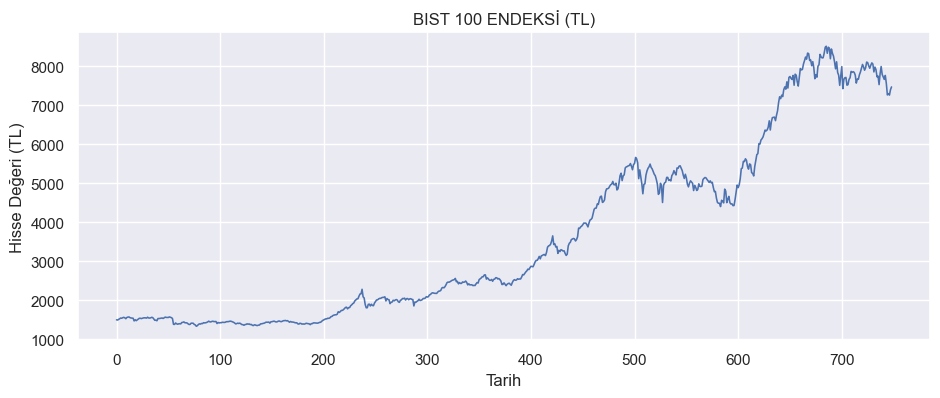

In [7]:
sns.set(rc={'figure.figsize':(11, 4)})
ax = df["Close"].plot(linestyle='-', linewidth=1.15, label='Daily')
ax.set_ylabel("Hisse Değeri (TL)")
ax.set_xlabel("Tarih")
ax.set_title("BIST 100 ENDEKSİ (TL)")
plt.show();

In [8]:
# Eğitim-Doğrulama-Test seti olarak bölelim
index = df.shape[0]*0.848
train = df[:int(index)]["Close"]
validation = df[int(index): int(df.shape[0]*0.925)]["Close"]
test = df[int(df.shape[0]*0.925):]["Close"]
final_train = pd.concat([validation, train], sort=False)

In [9]:
len(train), len(validation), len(test)

(635, 57, 57)

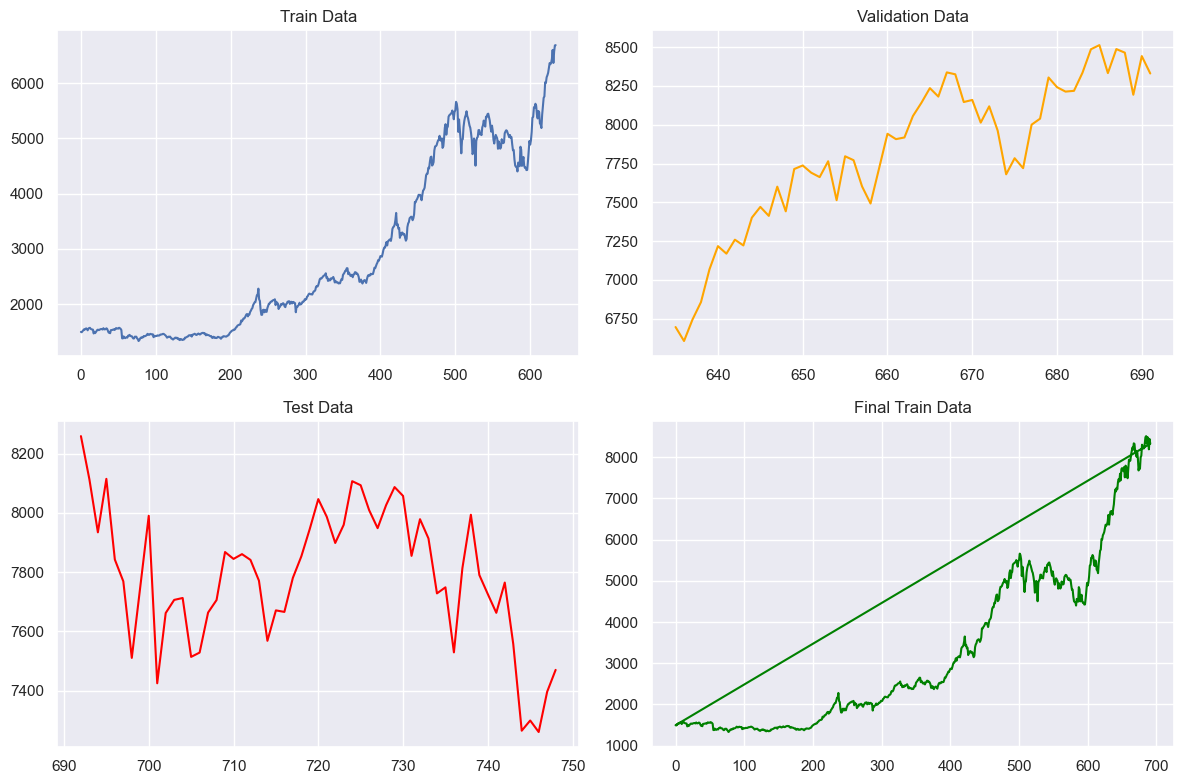

In [10]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
train.plot(ax=axes[0, 0], title="Train Data")
validation.plot(ax=axes[0, 1], title="Validation Data",color="orange")
test.plot(ax=axes[1, 0], title="Test Data",color="red")
final_train.plot(ax=axes[1, 1], title="Final Train Data",color="green")
plt.tight_layout()
plt.show();

# SES MODEL

## SES MODEL PARAMETRE OPTİMİZASYONU

In [11]:
index = df.shape[0]*0.848
train = df[:int(index)]["Close"]
validation = df[int(index): int(df.shape[0]*0.925)]["Close"]
test = df[int(df.shape[0]*0.925):]["Close"]
final_train = pd.concat([validation, train], sort=False)
len(train), len(validation), len(test)
def ses_optimizer(train, alphas, step=len(validation)):
    best_alpha, best_mae = None, float("inf")
    for alpha in alphas:
        ses_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha)
        validation_pred = ses_model.forecast(step)
        mae = mean_absolute_error(validation, validation_pred)
        if mae < best_mae:
            best_alpha, best_mae = alpha, mae
    print("best_alpha:", round(best_alpha, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_mae
alphas = np.arange(0.01, 1, 0.01)
best_alpha, best_mae = ses_optimizer(train, alphas, step=len(validation)) 
# best_alpha: best_alpha: 0.99 best_mae: 1137.2433

best_alpha: 0.99 best_mae: 1137.2433


### ONE STEP AHEAD METHOD(SES)

In [12]:
train = list(train)
validation = list(validation)
test = list(test)
final_train = list(final_train)
xu100_ses_model_predictions = []
n_test_obser = len(test)
for i in range(n_test_obser):
    model_fit = SimpleExpSmoothing(final_train).fit(smoothing_level=best_alpha)
    output = model_fit.forecast()
    yhat = output[0]
    xu100_ses_model_predictions.append(yhat)
    actual_test_value = test[i]
    final_train.append(actual_test_value)

### SES MODEL HATASI

In [13]:
xu100_ses_rmse = np.sqrt(mean_squared_error(test,xu100_ses_model_predictions)) # RMSE = 261.45944512132746
test = np.array(test)
xu100_ses_model_predictions = np.array(xu100_ses_model_predictions)
def mape(actual, predictions):
    mape = np.mean(np.abs((actual - predictions) / actual)) * 100
    return mape
xu100_ses_mape = mape(test,xu100_ses_model_predictions) # MAPE = 1.9154333675735422
print(xu100_ses_rmse), print(xu100_ses_mape);

261.45944512132746
1.9154333675735422


### SES MODELİN TAHMİN GRAFİĞİ:

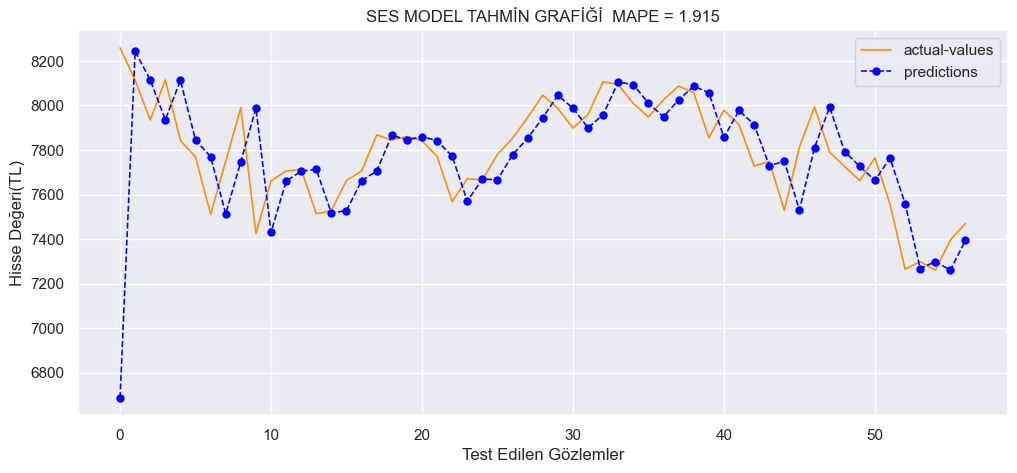

In [15]:
sns.set(rc={'figure.figsize':(12, 5)})
plt.plot(test,linestyle='-', linewidth=1.15, color="darkorange", label = 'actual-values')
plt.plot(xu100_ses_model_predictions,linestyle='dashed', linewidth=1.15, color="blue", marker="o",markersize=5, label = 'predictions')
plt.xlabel("Test Edilen Gözlemler")
plt.ylabel("Hisse Değeri(TL)")
plt.title("SES MODEL TAHMİN GRAFİĞİ  "+ "MAPE = " + str(round(xu100_ses_mape,3)))
plt.legend();

# DES MODEL

## DES MODEL PARAMETRE OPTİMİZASYONU

In [16]:
index = df.shape[0]*0.848
train = df[:int(index)]["Close"]
validation = df[int(index): int(df.shape[0]*0.925)]["Close"]
test = df[int(df.shape[0]*0.925):]["Close"]
final_train = pd.concat([validation, train], sort=False)
def des_optimizer(train, alphas, betas, step=len(validation)):
    best_alpha, best_beta, best_mae = None, None, float("inf")
    for alpha in alphas:
        for beta in betas:
            des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=alpha, smoothing_slope=beta)
            validation_pred = des_model.forecast(step)
            mae = mean_absolute_error(validation, validation_pred)
            if mae < best_mae:
                best_alpha, best_beta, best_mae = alpha, beta, mae
    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_beta, best_mae
alphas = np.arange(0.01, 1, 0.01)
betas = np.arange(0.1, 1, 0.01)
best_alpha, best_beta, best_mae = des_optimizer(train, alphas, betas, step=len(validation))
# best_alpha: 0.07 best_beta: 0.95 best_mae: 172.9779

best_alpha: 0.07 best_beta: 0.95 best_mae: 172.9779


### ONE STEP AHEAD METHOD(DES)

In [17]:
train = list(train)
validation = list(validation)
test = list(test)
final_train = list(final_train)
xu100_des_model_predictions = []
n_test_obser = len(test)
for i in range(n_test_obser):
    model_fit = ExponentialSmoothing(final_train, trend="add").fit(smoothing_level=best_alpha,
                                                         smoothing_slope=best_beta)
    output = model_fit.forecast()
    yhat = output[0]
    xu100_des_model_predictions.append(yhat)
    actual_test_value = test[i]
    final_train.append(actual_test_value)

### DES MODEL HATASI

In [19]:
xu100_des_rmse = np.sqrt(mean_squared_error(test,xu100_des_model_predictions)) # RMSE = 414.79814685607386
test = np.array(test)
xu100_des_model_predictions = np.array(xu100_des_model_predictions)
def mape(actual, predictions):
    mape = np.mean(np.abs((actual - predictions) / actual)) * 100
    return mape
xu100_des_mape = mape(test,xu100_des_model_predictions) # MAPE = 4.2749416453669244
print(xu100_des_rmse),print(xu100_des_mape); 

414.79814685607386
4.2749416453669244


### DES MODEL TAHMİN GRAFİĞİ:

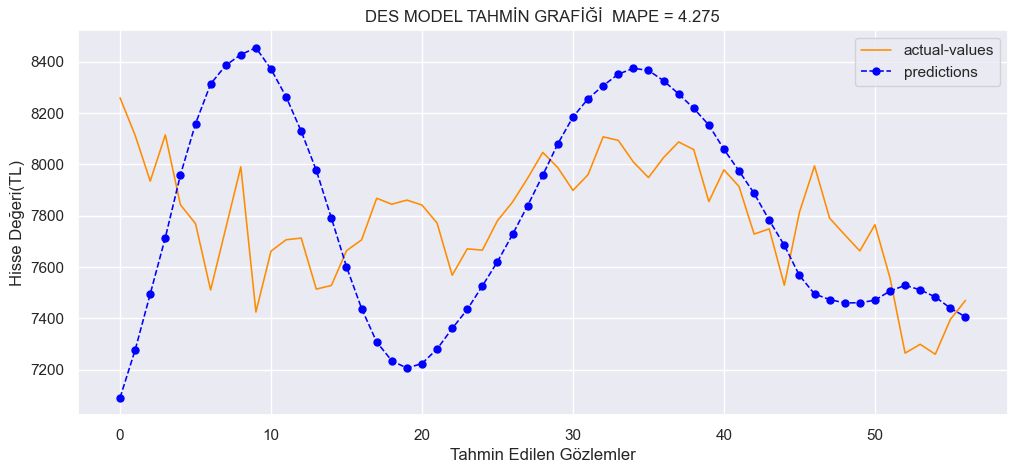

In [20]:
sns.set(rc={'figure.figsize':(12, 5)})
plt.plot(test,linestyle='-', linewidth=1.15, color="darkorange", label = 'actual-values')
plt.plot(xu100_des_model_predictions,linestyle='dashed', linewidth=1.15, color="blue", marker="o",markersize=5, label = 'predictions')
plt.xlabel("Tahmin Edilen Gözlemler")
plt.ylabel("Hisse Değeri(TL)")
plt.title("DES MODEL TAHMİN GRAFİĞİ  "+ "MAPE = " + str(round(xu100_des_mape,3)))
plt.legend();

# TES MODEL

## TES PARAMETRE OPTİMİZASYONU

In [21]:
len(validation), len(test)

(57, 57)

In [22]:
index = df.shape[0]*(0.84774)
train = df[:int(index)]["Close"]
validation = df[int(index): int(df.shape[0]*0.925)]["Close"]
test = df[int(df.shape[0]*0.925):]["Close"]
final_train = pd.concat([validation, train], sort=False)
def tes_optimizer(train, abg, step=len(validation)):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    for comb in abg:
        tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12).\
            fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
        validation_pred = tes_model.forecast(step)
        mae = mean_absolute_error(validation, validation_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae
    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_gamma:", round(best_gamma, 2),
          "best_mae:", round(best_mae, 4))

    return best_alpha, best_beta, best_gamma, best_mae
alphas = betas = gammas = np.arange(0.01, 1, 0.1)
abg = list(itertools.product(alphas, betas, gammas))
best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(train, abg, step=len(validation))
# best_alpha: 0.11 best_beta: 0.61 best_gamma: 0.11 best_mae: 196.4907

best_alpha: 0.11 best_beta: 0.61 best_gamma: 0.11 best_mae: 196.4907


### ONE STEP AHEAD METHOD(TES)

In [23]:
train = list(train)
validation = list(validation)
test = list(test)
final_train = list(final_train)
xu100_tes_model_predictions = []
n_test_obser = len(test)
for i in range(n_test_obser):
    model_fit = ExponentialSmoothing(final_train, trend="add", seasonal="add", seasonal_periods=5).\
            fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)
    # model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    xu100_tes_model_predictions.append(yhat)
    actual_test_value = test[i]
    final_train.append(actual_test_value)

### TES MODEL HATASI

In [24]:
xu100_tes_rmse = np.sqrt(mean_squared_error(test,xu100_tes_model_predictions)) # RMSE = 402.18919408910045
test = np.array(test)
xu100_tes_model_predictions = np.array(xu100_tes_model_predictions)
def mape(actual, predictions):
    mape = np.mean(np.abs((actual - predictions) / actual)) * 100
    return mape
xu100_tes_mape = mape(test,xu100_tes_model_predictions) # MAPE = 3.6552934962521904
print("RMSE =",xu100_tes_rmse),print("MAPE =",xu100_tes_mape);

RMSE = 402.18919408910045
MAPE = 3.6552934962521904


### TES MODEL TAHMİN GRAFİĞİ:

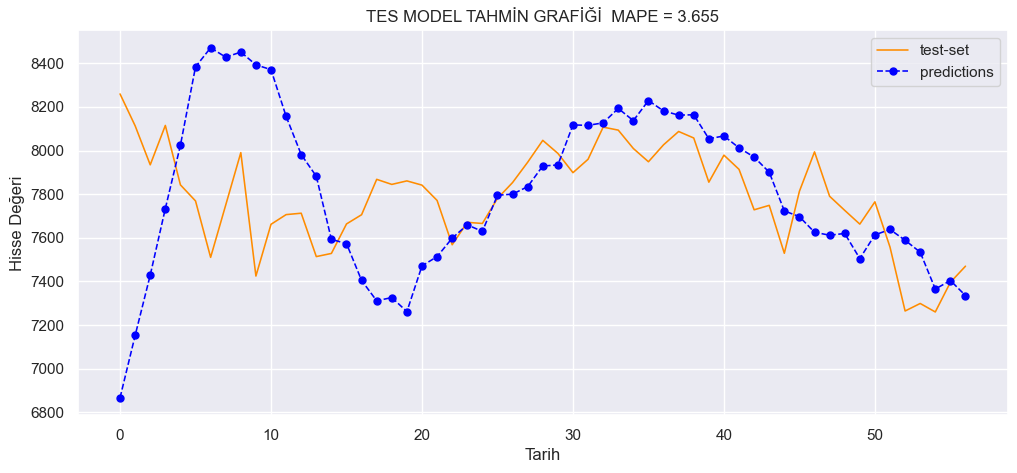

In [25]:
sns.set(rc={'figure.figsize':(12, 5)})
plt.plot(test,linestyle='-', linewidth=1.15, color="darkorange", label = 'test-set')
plt.plot(xu100_tes_model_predictions,linestyle='dashed', linewidth=1.15, color="blue", marker="o",markersize=5, label = 'predictions')
plt.xlabel("Tarih")
plt.ylabel("Hisse Değeri")
plt.title("TES MODEL TAHMİN GRAFİĞİ  "+ "MAPE = " + str(round(xu100_tes_mape,3)))
plt.legend();

# ARIMA MODEL

## ARIMA MODEL PARAMETRE OPTMİZASYONU

In [26]:
index = df.shape[0]*0.848
train = df[:int(index)]["Close"]
validation = df[int(index): int(df.shape[0]*0.925)]["Close"]
test = df[int(df.shape[0]*0.925):]["Close"]
final_train = pd.concat([validation, train], sort=False)
p = d = q = range(0, 4)
pdq = list(itertools.product(p, d, q))
def arima_optimizer_aic(train, orders):
    best_aic, best_params = float("inf"), None
    for order in orders:
        try:
            arima_model = sm.tsa.ARIMA(train, order=order).fit()
            aic = arima_model.aic
            if aic < best_aic:
                best_aic, best_params = aic, order
        except:
            continue
    print('Best ARIMA%s AIC=%.2f' % (best_params, best_aic))
    return best_params
best_params_aic = arima_optimizer_aic(train, pdq)
# Best ARIMA(2, 2, 3) AIC=7246.65  <- parametreler.

Best ARIMA(2, 2, 3) AIC=7246.65


### ONE STEP AHEAD METHOD(ARIMA)

In [27]:
train = list(train)
validation = list(validation)
test = list(test)
final_train = list(final_train)
xu100_arima_model_predictions = []
n_test_obser = len(test)
for i in range(n_test_obser):
    model = sm.tsa.ARIMA(final_train, order=best_params_aic)
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    xu100_arima_model_predictions.append(yhat)
    actual_test_value = test[i]
    final_train.append(actual_test_value)

### ARIMA MODEL HATASI

In [28]:
xu100_arima_rmse = np.sqrt(mean_squared_error(test,xu100_arima_model_predictions)) # RMSE = 263.95115260389986
test = np.array(test)
xu100_arima_model_predictions = np.array(xu100_arima_model_predictions)
def mape(actual, predictions):
    mape = np.mean(np.abs((actual - predictions) / actual)) * 100
    return mape
xu100_arima_mape = mape(test,xu100_arima_model_predictions) # MAPE = 1.9770091022340845
print("RMSE =",xu100_arima_rmse),print("MAPE =",xu100_arima_mape);

RMSE = 263.95115260389986
MAPE = 1.9770091022340845


### ARIMA MODEL TAHMİN GRAFİĞİ:

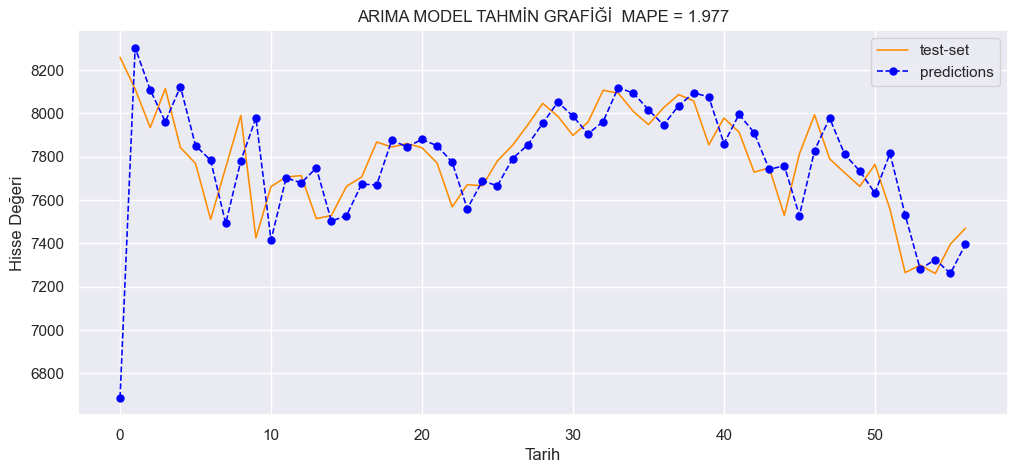

In [29]:
sns.set(rc={'figure.figsize':(12, 5)})
plt.plot(test,linestyle='-', linewidth=1.15, color="darkorange", label = 'test-set')
plt.plot(xu100_arima_model_predictions,linestyle='dashed', linewidth=1.15, color="blue", marker="o",markersize=5, label = 'predictions')
plt.xlabel("Tarih")
plt.ylabel("Hisse Değeri")
plt.title("ARIMA MODEL TAHMİN GRAFİĞİ  "+ "MAPE = " + str(round(xu100_arima_mape,3)))
plt.legend();

# SARIMA MODEL

## SARIMA MODEL PARAMETRE OPTİMİZASYONU

In [30]:
index = df.shape[0]*0.848
train = df[:int(index)]["Close"]
validation = df[int(index): int(df.shape[0]*0.925)]["Close"]
test = df[int(df.shape[0]*0.925):]["Close"]
final_train = pd.concat([validation, train], sort=False)
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 5) for x in list(itertools.product(p, d, q))]
def sarima_optimizer_aic(train, pdq, seasonal_pdq):
    best_aic, best_order, best_seasonal_order = float("inf"), None, None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                sarimax_model = SARIMAX(train, order=param, seasonal_order=param_seasonal)
                results = sarimax_model.fit(disp=0)
                aic = results.aic
                if aic < best_aic:
                    best_aic, best_order, best_seasonal_order = aic, param, param_seasonal
            except:
                continue
    print('SARIMA{}x{}12 - AIC:{}'.format(best_order, best_seasonal_order, best_aic))
    return best_order, best_seasonal_order
best_order, best_seasonal_order = sarima_optimizer_aic(train, pdq, seasonal_pdq)
# SARIMA(0, 1, 0)x(1, 1, 1, 5)12 - AIC:7228.660814891668 <- parametreler.

SARIMA(0, 1, 0)x(1, 1, 1, 5)12 - AIC:7228.660814891668


### ONE STEP AHEAD METHOD(SARIMA)

In [31]:
train = list(train)
validation = list(validation)
test = list(test)
final_train = list(final_train)
xu100_sarima_model_predictions = []
n_test_obser = len(test)
for i in range(n_test_obser):
    model = SARIMAX(final_train, order=best_order, seasonal_order=best_seasonal_order)
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    xu100_sarima_model_predictions.append(yhat)
    actual_test_value = test[i]
    final_train.append(actual_test_value)

### SARIMA MODEL HATASI

In [32]:
xu100_sarima_rmse = np.sqrt(mean_squared_error(test,xu100_sarima_model_predictions)) # RMSE = 264.0442915899836
test = np.array(test)
xu100_sarima_model_predictions = np.array(xu100_sarima_model_predictions)
def mape(actual, predictions):
    mape = np.mean(np.abs((actual - predictions) / actual)) * 100
    return mape
xu100_sarima_mape = mape(test,xu100_sarima_model_predictions) # MAPE = 1.8718753057574797
print("RMSE =",xu100_sarima_rmse),print("MAPE =",xu100_sarima_mape);

RMSE = 264.0442915899836
MAPE = 1.8718753057574797


### SARIMA MODEL TAHMİN GRAFİĞİ:

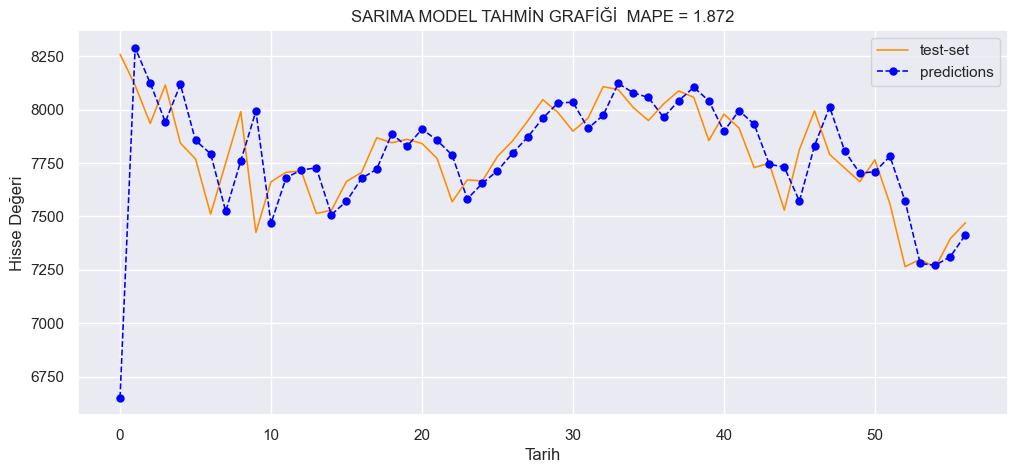

In [33]:
sns.set(rc={'figure.figsize':(12, 5)})
plt.plot(test,linestyle='-', linewidth=1.15, color="darkorange", label = 'test-set')
plt.plot(xu100_sarima_model_predictions,linestyle='dashed', linewidth=1.15, color="blue", marker="o",markersize=5, label = 'predictions')
plt.xlabel("Tarih")
plt.ylabel("Hisse Değeri")
plt.title("SARIMA MODEL TAHMİN GRAFİĞİ  "+ "MAPE = " + str(round(xu100_sarima_mape,3)))
plt.legend();

# ANN MODEL(LSTM)

In [34]:
data = pd.read_csv("xu100.csv")
prices = data['Close'].values

In [35]:
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(prices.reshape(-1, 1))

In [36]:
def create_dataset(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(X), np.array(y)
lookback = 30

In [37]:
train_size = int(len(prices_scaled) * 0.925) 
train_data = prices_scaled[:train_size]
test_data = prices_scaled[train_size - lookback:]  
train_size, len(train_data), len(test_data)

(692, 692, 87)

In [38]:
# Ayrı ayrı veri seti oluştur
X_train, y_train = create_dataset(train_data, lookback)
X_test, y_test = create_dataset(test_data, lookback)
# LSTM için giriş verisini yeniden şekillendir
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [39]:
# Model oluştur
tf.random.set_seed(42)
model = Sequential([
    LSTM(50, activation='relu', input_shape=(lookback, 1)),
    Dense(1)])
# Modeli derle
model.compile(optimizer='adam', loss='mse')
# Modeli eğit
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0531 - val_loss: 0.0093
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011 - val_loss: 0.0056
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.1447e-04 - val_loss: 0.0035
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.2881e-04 - val_loss: 0.0019
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.1608e-04 - val_loss: 0.0013
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.0189e-04 - val_loss: 0.0013
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7925e-04 - val_loss: 0.0012
Epoch 8/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.7155e-04 - val_loss: 0.0011
Epoch 9/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.6080e-04 - val_loss: 0.0011
Epoch 10/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5546e-04 - val_loss: 0.0010
Epoch 11/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4700e-04 - val_loss: 9.9873e-04
Epoch 12/20
42/42 ━━━━━━━━━━━━━━━━

In [40]:
xu100_ann_pred = model.predict(X_test)
# Veriyi orijinal ölçeğe geri çevir
y_pred_ann_inverse = scaler.inverse_transform(xu100_ann_pred)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))
def mape(actual, predictions):
    return np.mean(np.abs((actual - predictions) / actual)) * 100
xu100_ann_mape = mape(y_test_inverse, y_pred_ann_inverse)
print(xu100_ann_mape) # MAPE = 2.1518907440348682

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2.1518907440348682


In [41]:
test = np.array(y_test_inverse)
xu100_ann_model_predictions = np.array(y_pred_ann_inverse)

### ANN MODEL TAHMİN GRAFİĞİ:

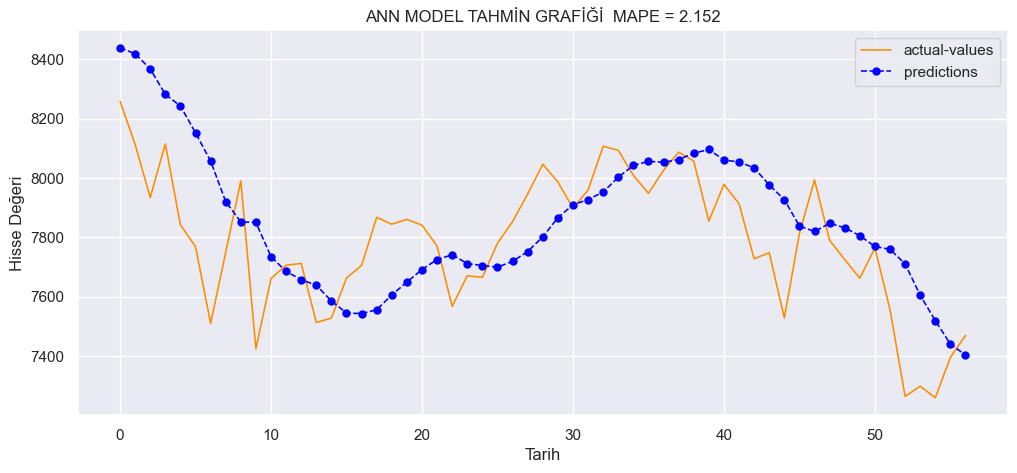

In [43]:
plt.plot(test,linestyle='-', linewidth=1.15, color="darkorange", label = 'actual-values')
plt.plot(xu100_ann_model_predictions,linestyle='dashed', linewidth=1.15, color="blue", marker="o",markersize=5, label = 'predictions')
plt.xlabel("Tarih")
plt.ylabel("Hisse Değeri")
plt.title("ANN MODEL TAHMİN GRAFİĞİ  "+ "MAPE = " + str(round(xu100_ann_mape,3)))
plt.legend();

# CNN MODEL

In [59]:
from tensorflow.keras.layers import Conv1D, Dense, Flatten

In [97]:
data = pd.read_csv("xu100.csv")
prices = data["Close"].values

In [74]:
len(validation), len(test)

(57, 57)

In [98]:
# Parametreler
lookback = 10
test_size = 57
# Veriyi böl (lookback'i unutma!)
train_prices = prices[:-(test_size)]
test_prices = prices[-(test_size + lookback):]  # Test için lookback öncesi veriler dahil edilir
# Ölçeklendirme (sadece train'e fit et)
scaler = MinMaxScaler(feature_range=(0, 1))
train_prices_scaled = scaler.fit_transform(train_prices.reshape(-1, 1))
test_prices_scaled = scaler.transform(test_prices.reshape(-1, 1))

In [99]:
# Dataset oluşturma fonksiyonu
def create_dataset(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(X), np.array(y)
X_train, y_train = create_dataset(train_prices_scaled, lookback)
X_test, y_test = create_dataset(test_prices_scaled, lookback)

In [100]:
# CNN için reshape
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [107]:
# Model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(lookback, 1)))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
# Compile
model.compile(optimizer='adam', loss='mse')
# Eğitim
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test));

Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0289 - val_loss: 9.6121e-04
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - loss: 7.5057e-04 - val_loss: 0.0014
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.9819e-04 - val_loss: 0.0013
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.4498e-04 - val_loss: 0.0019
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0322e-04 - val_loss: 0.0022
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.8299e-04 - val_loss: 0.0025
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.5813e-04 - val_loss: 0.0018
Epoch 8/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.3003e-04 - val_loss: 0.0012
Epoch 9/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.0870e-04 - val_loss: 9.1613e-04
Epoch 10/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.8332e-04 - val_loss: 8.6356e-04
Epoch 11/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.5087e-04 - val_loss: 8.8306e-04
Epoch 12/20
43/4

In [108]:
y_pred_scaled = model.predict(X_test)
xu100_cnn_y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))
def mape(actual, pred):
    return np.mean(np.abs((actual - pred) / actual)) * 100
xu100_cnn_mape = mape(y_test_inverse, xu100_cnn_y_pred)
print(f"Test MAPE: {xu100_cnn_mape}") # Test MAPE: 1.8866190708373582

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Test MAPE: 1.8866190708373582


###  CNN MODEL TAHMİN GRAFİĞİ:

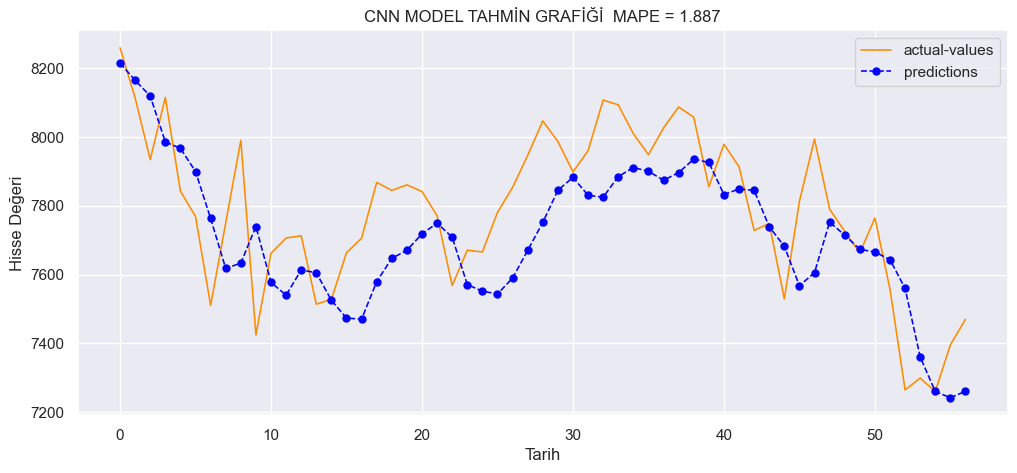

In [109]:
import matplotlib.pyplot as plt
plt.plot(y_test_inverse,linestyle='-', linewidth=1.15, color="darkorange", label = 'actual-values')
plt.plot(xu100_cnn_y_pred,linestyle='dashed', linewidth=1.15, color="blue", marker="o",markersize=5, label = 'predictions')
plt.xlabel("Tarih")
plt.ylabel("Hisse Değeri")
plt.title("CNN MODEL TAHMİN GRAFİĞİ  "+ "MAPE = " + str(round(xu100_cnn_mape,3)))
plt.legend();

#

## KOMBİNASYON YÖNTEMİ VE BAŞARISI

## YÖNTEMLERİN MAPE DEĞERLERİ:

In [110]:
best_model = pd.DataFrame([xu100_ses_mape, xu100_des_mape, xu100_tes_mape,
                           xu100_arima_mape, xu100_sarima_mape,
                           xu100_ann_mape, xu100_cnn_mape],

                          index=["SES MODEL", "DES MODEL", "TES MODEL", "ARIMA MODEL", "SARIMA MODEL","ANN MODEL","CNN MODEL"],

                          columns=["MAPE Değerleri"])
print(best_model.sort_values("MAPE Değerleri", ascending=True));

              MAPE Değerleri
SARIMA MODEL        1.871875
CNN MODEL           1.886619
SES MODEL           1.915433
ARIMA MODEL         1.977009
ANN MODEL           2.151891
TES MODEL           3.655293
DES MODEL           4.274942


**EN DÜŞÜK MAPE DEĞERİNE SAHİP 3 YÖNTEMİN ORTALAMASINI ALALIM**

In [111]:
predictions = np.stack([xu100_sarima_model_predictions.flatten(),xu100_cnn_y_pred.flatten(), xu100_ses_model_predictions.flatten(),], axis=1)

# Bu tahminlerin ortalaması:
average_predictions = np.mean(predictions, axis=1)

print(average_predictions)

[7184.50587109 8232.56501012 8118.96383712 7954.66205304 8065.97741068
 7866.76719444 7775.42947149 7551.68525247 7713.93817446 7906.76634063
 7491.60290291 7627.13503351 7678.8431908  7681.9039017  7516.5356782
 7524.40891135 7603.55113451 7668.75550551 7800.00539115 7781.09252952
 7829.25648326 7815.88215444 7755.82156256 7574.48628562 7625.56470719
 7641.1676295  7721.77817427 7798.01054808 7885.56655112 7973.7548217
 7968.36023127 7880.66581471 7919.1292724  8037.67840164 8027.67939525
 7989.02701236 7929.00710719 7987.7244923  8042.02657815 8008.35156698
 7862.70835662 7940.4808104  7896.99851368 7737.9712003  7720.54947797
 7556.93164491 7748.97670374 7919.03761845 7770.98845491 7700.76261716
 7679.54151744 7729.49247098 7563.4917855  7302.71755054 7276.95494063
 7271.74149288 7356.89395588]


**KOMBİNE EDİLEN TAHMİNLERİN MAPE DEĞERİ**

In [112]:
from sklearn.metrics import mean_absolute_percentage_error
combined_mape = mean_absolute_percentage_error(test,average_predictions)*100
print(combined_mape) #  MAPE = 1.783756486344527

1.783756486344527


In [121]:
xu100_cnn_rmse = np.sqrt(mean_squared_error(test,xu100_cnn_y_pred)) # RMSE = 175.07996412699487
print(xu100_cnn_rmse);

175.07996412699487


# 

In [123]:
best_model = pd.DataFrame([xu100_sarima_mape, xu100_ses_mape,
                        xu100_cnn_mape,combined_mape],

                          index=["SARIMA MODEL", "SES MODEL","ARIMA MODEL","COMBINED PREDICTION"],

                          columns=["XU100 MAPE Değerleri"])
print(best_model.sort_values("XU100 MAPE Değerleri", ascending=True));

                     XU100 MAPE Değerleri
COMBINED PREDICTION              1.783756
SARIMA MODEL                     1.871875
ARIMA MODEL                      1.886619
SES MODEL                        1.915433


In [115]:
combined_RMSE = np.sqrt(mean_squared_error(test,average_predictions)) # RMSE = 207.61650005136607
print(combined_RMSE);

207.61650005136607


In [124]:
best_model_RMSE = pd.DataFrame([xu100_arima_rmse, xu100_sarima_rmse,
                           xu100_cnn_rmse, combined_RMSE],

                          index=["ARIMA MODEL", "SARIMA MODEL","CNN MODEL","COMBINED PREDICTION"],

                          columns=["XU100 RMSE Değerleri"])
print(best_model_RMSE.sort_values("XU100 RMSE Değerleri", ascending=True));

                     XU100 RMSE Değerleri
CNN MODEL                      175.079964
COMBINED PREDICTION            207.616500
ARIMA MODEL                    263.951153
SARIMA MODEL                   264.044292


**YÖNTEMLERİN MAPE DEĞERLERİ BİRBİRİNE ÇOK YAKIN GELMİŞTİR. KOMBİNASYON İLE ELDE EDİLEN TAHMİNLERİN MAPE DEĞERİ 1. SIRADA YER ALMIŞTIR!**

## KOMBİNE TAHMİNLERİN GRAFİĞİ:

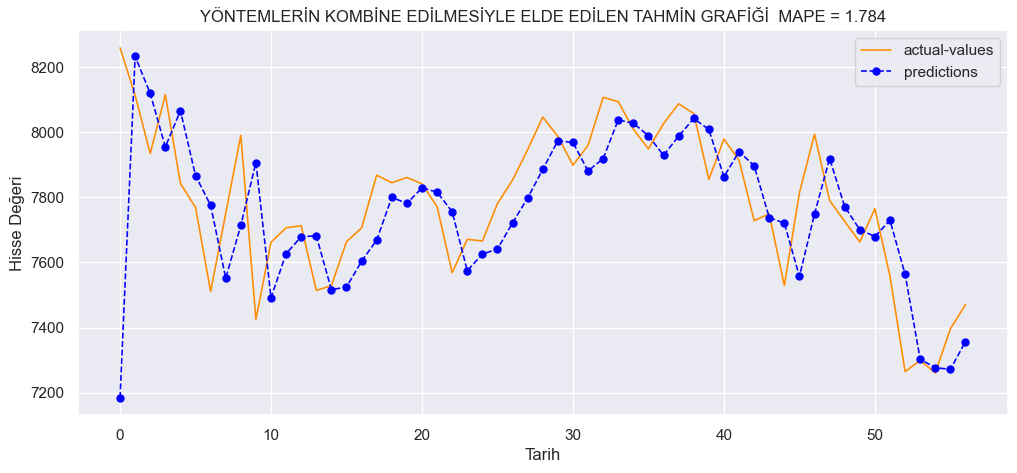

In [114]:
import matplotlib.pyplot as plt
plt.plot(y_test_inverse,linestyle='-', linewidth=1.15, color="darkorange", label = 'actual-values')
plt.plot(average_predictions,linestyle='dashed', linewidth=1.15, color="blue", marker="o",markersize=5, label = 'predictions')
plt.xlabel("Tarih")
plt.ylabel("Hisse Değeri")
plt.title("YÖNTEMLERİN KOMBİNE EDİLMESİYLE ELDE EDİLEN TAHMİN GRAFİĞİ  "+ "MAPE = " + str(round(combined_mape,3)))
plt.legend();